In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

from rich import print
from scipy.stats import gaussian_kde
from pathlib import Path

from tqdm.auto import tqdm
from scipy.io import loadmat

c:\Users\zcc\Anaconda3\envs\eeg-for-everyone\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\zcc\Anaconda3\envs\eeg-for-everyone\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


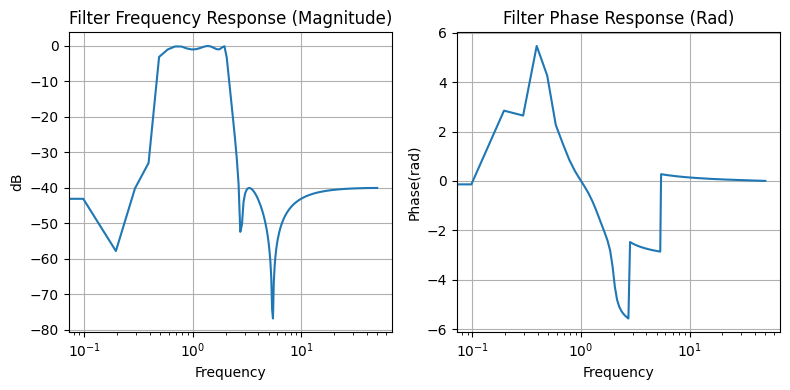

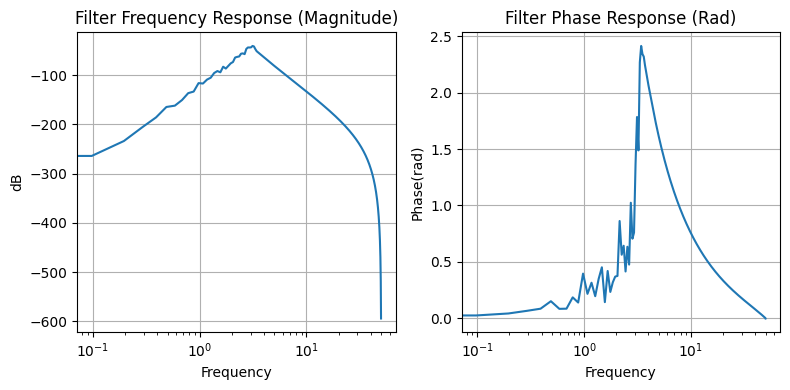

In [2]:
from scipy import signal

class FilterOption1:
    '''
    Default option for bandpass digital filter
        wp, ws : float, Passband and stopband edge frequencies.
        gpass : float, The maximum loss in the passband (dB).
        gstop : float, The minimum attenuation in the stopband (dB).
        rp : float, The maximum ripple allowed below unity gain in the passband. Specified in decibels, as a positive number.
        rs : float, The minimum attenuation required in the stop band. Specified in decibels, as a positive number.
        btype : {'lowpass', 'highpass', 'bandpass', 'bandstop'}, The type of filter. Default is 'lowpass'.
    '''
    wp = [0.5, 2.0]
    ws = [0.1, 3.0]
    gpass=3
    gstop=40
    rp=1
    rs=40
    btype = 'bandpass'
    help = dict(
        method = 'ellip',
        order  = signal.ellipord,
        design = signal.ellip
    )

class FilterOption2:
    wp = [0.5, 2.0]
    ws = [0.05, 3.0]
    gpass=3
    gstop=40
    rp=1
    rs=40
    btype = 'bandpass'
    help = dict(
        method = 'butter',
        order  = signal.buttord,
        design = signal.butter
    )

class MyFilter(object):
    # Sampling frequency
    sfreq = 100
    default=FilterOption1
    
    def __init__(self, sfreq=None, default=None):
        if sfreq:
            self.sfreq = sfreq
        if default:
            self.default = default

    def design_filter(self, **kwargs):
        '''
        Design the filter
        '''

        # Fetch options
        sfreq = self.sfreq
        wp = kwargs.get('wp', self.default.wp)
        ws = kwargs.get('ws', self.default.ws)
        gpass = kwargs.get('gpass', self.default.gpass)
        gstop = kwargs.get('gstop', self.default.gstop)
        rp = kwargs.get('rp', self.default.rp)
        rs = kwargs.get('rs', self.default.rs)
        btype = kwargs.get('btype', self.default.btype)
        
        # Convert wp and ws to digital frequencies
        nf = sfreq / 2
        # wp = np.array(wp) / nf
        # ws = np.array(ws) / nf

        method = self.default.help.get('method')
        if method == 'ellip':
            # Order selection, Elliptic (Cauer) filter order selection.
            N, Wn = signal.ellipord(wp, ws, gpass, gstop, fs=sfreq)
            
            # Filter design, Elliptic (Cauer) digital and analog filter design.
            ba = signal.ellip(N, rp, rs, Wn, btype, output='ba', fs=sfreq)

        elif method == 'butter':
            N, Wn = signal.buttord(wp, ws, gpass, gstop, fs=sfreq)
            ba = signal.butter(N, Wn, btype, output='ba', fs=sfreq)
            
        self.ba = ba
        
        return ba

    def filter(self, ts:np.ndarray, **kwargs):
        '''
        Filter the time series
        '''
        b, a = self.ba
        filtered = signal.filtfilt(b, a, ts, **kwargs)
        self.latest = (ts, filtered)
        return filtered

    def plot_latest_filtered(self, times=None):
        '''
        Plot the latest filtered time series
        '''
        ts, filtered = self.latest
        if times is None:
            times = np.linspace(0, 1, len(ts))
            
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        ax = axs[0]
        ax.plot(times, ts.T, label='raw')
        ax.grid(True)
        ax.set_title('Before filter')
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')

        ax = axs[1]
        ax.plot(times, filtered.T, label='filtered')
        ax.grid(True)
        ax.set_title('After filter')
        ax.set_xlabel('Time (seconds)')
        ax.set_ylabel('Value')

        fig.tight_layout()
        
        return fig

    def plot_filter(self):
        '''
        Plot the filter
        '''
        
        sfreq = self.sfreq
        b, a = self.ba

        # Compute the frequency response of a digital filter,
        # convert them to real freq
        w, h = signal.freqz(b, a)
        w /= np.pi
        w *= sfreq / 2
    
        # Plot
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    
        # Plot freq response
        ax = axs[0]
        ax.semilogx(w, 20*np.log10(h))
        ax.set_xlabel('Frequency')
        ax.set_ylabel('dB')
        ax.set_title('Filter Frequency Response (Magnitude)')
        ax.grid(True)
    
        # Plot phase response
        ax = axs[1]
        ax.semilogx(w, np.unwrap(np.angle(h)))
        ax.set_xlabel('Frequency')
        ax.set_ylabel('Phase(rad)')
        ax.set_title('Filter Phase Response (Rad)')
        ax.grid(True)
    
        fig.tight_layout()
        return fig

_mf = MyFilter(default=FilterOption1)
_mf.design_filter()
fig = _mf.plot_filter()

_mf = MyFilter(default=FilterOption2)
_mf.design_filter()
fig = _mf.plot_filter()

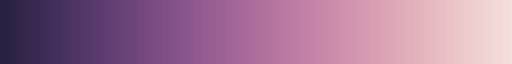

In [3]:
cmap = sns.cubehelix_palette(start=2.9, light=0.9, as_cmap=True, reverse=True)
cmap = cmap.with_extremes(bad=cmap(0))
cmap

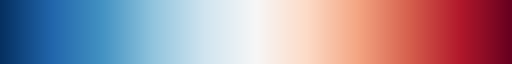

In [4]:
cmap1 = plt.colormaps["RdBu_r"]
cmap1 = cmap1.with_extremes(bad=cmap1(0))
cmap1

## Read data

In [5]:
def read_data(path, ch_name='O1'):
    path = Path(path)
    
    package = loadmat(path)
    data = package.get('data')
    times = package.get('times')
    ch_names = package.get('ch_names')

    # Prepare data
    times = times.squeeze()
    ch_names = np.array([e.strip() for e in ch_names])

    # Fetch ch_name
    name = np.array(ch_name, dtype=ch_names.dtype)
    selected_data = data[:, ch_names==name].squeeze()

    print('\n-----------------------------------------------------')
    print(f'Using data: {path}, selecting ch: {ch_name}')
    print('It contains', package.keys())
    print('data', type(data), data.shape)
    print('selected_data', type(selected_data), selected_data.shape)
    print('times', type(times), times.shape)
    print('ch_names', type(ch_names), len(ch_names), ch_names)
    
    return dict(
        data=data,
        times=times,
        ch_names=ch_names,
        selected_data=selected_data
    )

In [6]:
read_a1 = read_data('./private/a-1.mat')
read_a2 = read_data('./private/a-2.mat')
read_b1 = read_data('./private/b-1.mat')
read_b2 = read_data('./private/b-2.mat')

-----------------------------------------------------

Using data: private\a-1.mat, selecting ch: O1

It contains dict_keys(['__header__', '__version__', '__globals__', 'data', 'times', 'ch_names'])

data <class 'numpy.ndarray'>
(472, 64, 151)

selected_data <class 'numpy.ndarray'>
(472, 151)

times <class 'numpy.ndarray'>
(151,)

ch_names <class 'numpy.ndarray'> 64 ['FPZ' 'FP1' 'FP2' 'AF3' 'AF4' 'AF7' 'AF8' 'FZ' 'F1' 'F2' 'F3' 'F4' 'F5'
 'F6' 'F7' 'F8' 'FCZ' 'FC1' 'FC2' 'FC3' 'FC4' 'FC5' 'FC6' 'FT7' 'FT8' 'CZ'
 'C1' 'C2' 'C3' 'C4' 'C5' 'C6' 'T7' 'T8' 'CP1' 'CP2' 'CP3' 'CP4' 'CP5'
 'CP6' 'TP7' 'TP8' 'PZ' 'P3' 'P4' 'P5' 'P6' 'P7' 'P8' 'POZ' 'PO3' 'PO4'
 'PO5' 'PO6' 'PO7' 'PO8' 'OZ' 'O1' 'O2' 'ECG' 'HEOR' 'HEOL' 'VEOU' 'VEOL']

-----------------------------------------------------

Using data: private\a-2.mat, selecting ch: O1

It contains dict_keys(['__header__', '__version__', '__globals__', 'data', 'times', 'ch_names'])

data <class 'numpy.ndarray'>
(59, 64, 151)

selected_data <class 'numpy.ndarray'>
(59, 151)

times <class 'numpy.ndarray'>
(151,)

ch_names <class 'numpy.ndarray'> 64 ['FPZ' 'FP1' 'FP2' 'AF3' 'AF4' 'AF7' 'AF8' 'FZ' 'F1' 'F2' 'F3' 'F4' 'F5'
 'F6' 'F7' 'F8' 'FCZ' 'FC1' 'FC2' 'FC3' 'FC4' 'FC5' 'FC6' 'FT7' 'FT8' 'CZ'
 'C1' 'C2' 'C3' 'C4' 'C5' 'C6' 'T7' 'T8' 'CP1' 'CP2' 'CP3' 'CP4' 'CP5'
 'CP6' 'TP7' 'TP8' 'PZ' 'P3' 'P4' 'P5' 'P6' 'P7' 'P8' 'POZ' 'PO3' 'PO4'
 'PO5' 'PO6' 'PO7' 'PO8' 'OZ' 'O1' 'O2' 'ECG' 'HEOR' 'HEOL' 'VEOU' 'VEOL']

-----------------------------------------------------

Using data: private\b-1.mat, selecting ch: O1

It contains dict_keys(['__header__', '__version__', '__globals__', 'data', 'times', 'ch_names'])

data <class 'numpy.ndarray'>
(720, 64, 151)

selected_data <class 'numpy.ndarray'>
(720, 151)

times <class 'numpy.ndarray'>
(151,)

ch_names <class 'numpy.ndarray'> 64 ['FPZ' 'FP1' 'FP2' 'AF3' 'AF4' 'AF7' 'AF8' 'FZ' 'F1' 'F2' 'F3' 'F4' 'F5'
 'F6' 'F7' 'F8' 'FCZ' 'FC1' 'FC2' 'FC3' 'FC4' 'FC5' 'FC6' 'FT7' 'FT8' 'CZ'
 'C1' 'C2' 'C3' 'C4' 'C5' 'C6' 'T7' 'T8' 'CP1' 'CP2' 'CP3' 'CP4' 'CP5'
 'CP6' 'TP7' 'TP8' 'PZ' 'P3' 'P4' 'P5' 'P6' 'P7' 'P8' 'POZ' 'PO3' 'PO4'
 'PO5' 'PO6' 'PO7' 'PO8' 'OZ' 'O1' 'O2' 'ECG' 'HEOR' 'HEOL' 'VEOU' 'VEOL']

-----------------------------------------------------

Using data: private\b-2.mat, selecting ch: O1

It contains dict_keys(['__header__', '__version__', '__globals__', 'data', 'times', 'ch_names'])

data <class 'numpy.ndarray'>
(90, 64, 151)

selected_data <class 'numpy.ndarray'>
(90, 151)

times <class 'numpy.ndarray'>
(151,)

ch_names <class 'numpy.ndarray'> 64 ['FPZ' 'FP1' 'FP2' 'AF3' 'AF4' 'AF7' 'AF8' 'FZ' 'F1' 'F2' 'F3' 'F4' 'F5'
 'F6' 'F7' 'F8' 'FCZ' 'FC1' 'FC2' 'FC3' 'FC4' 'FC5' 'FC6' 'FT7' 'FT8' 'CZ'
 'C1' 'C2' 'C3' 'C4' 'C5' 'C6' 'T7' 'T8' 'CP1' 'CP2' 'CP3' 'CP4' 'CP5'
 'CP6' 'TP7' 'TP8' 'PZ' 'P3' 'P4' 'P5' 'P6' 'P7' 'P8' 'POZ' 'PO3' 'PO4'
 'PO5' 'PO6' 'PO7' 'PO8' 'OZ' 'O1' 'O2' 'ECG' 'HEOR' 'HEOL' 'VEOU' 'VEOL']

In [26]:
r = read_b2
data = r.get('data')
times = r.get('times')
ch_names = r.get('ch_names')
selected_data = r.get('selected_data')

In [27]:
selected_data_a1 = read_a1.get('selected_data')
selected_data_a2 = read_a2.get('selected_data')
selected_data_b1 = read_b1.get('selected_data')
selected_data_b2 = read_b2.get('selected_data')

  0%|          | 0/90 [00:00<?, ?it/s]

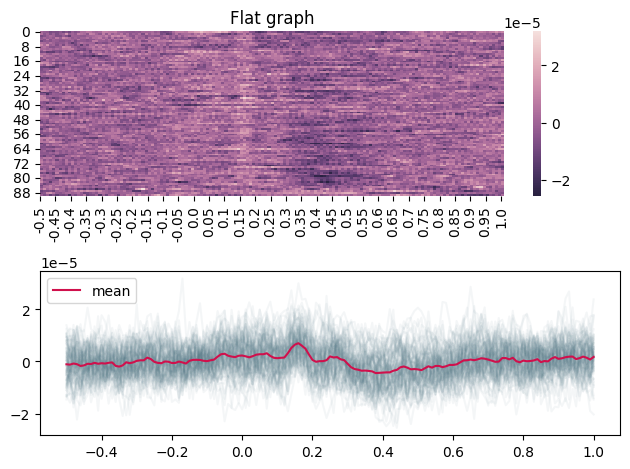

In [28]:
fig, axs = plt.subplots(2, 1)

ax = axs[0]
ax.set_title('Flat graph')
sns.heatmap(selected_data, square=False, cmap=cmap, ax=ax)
ax.set_xticks(range(len(times))[::5], times[::5])

ax = axs[1]
for y in tqdm(selected_data):
    sns.lineplot(x=times, y=y, color='#577C8A10', legend=False, ax=ax)
sns.lineplot(x=times, y=np.mean(selected_data, axis=0), label='mean', color='#D0104C', legend='auto', ax=ax)

fig.tight_layout()
plt.show()

## Filter

(151,)

(90, 151)

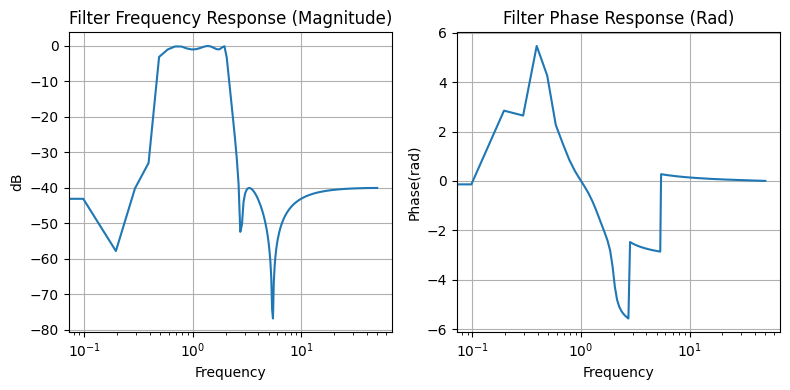

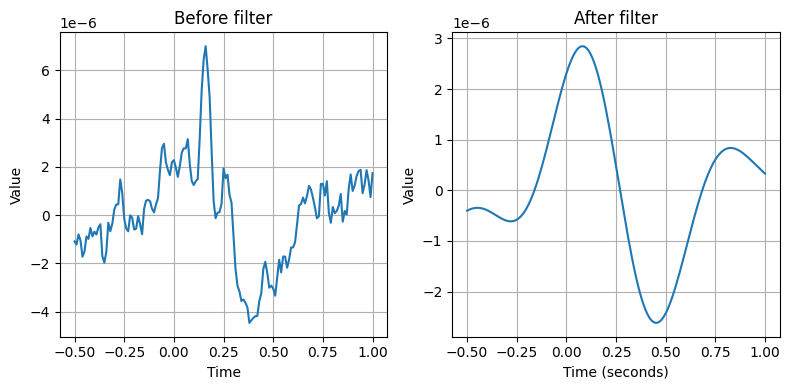

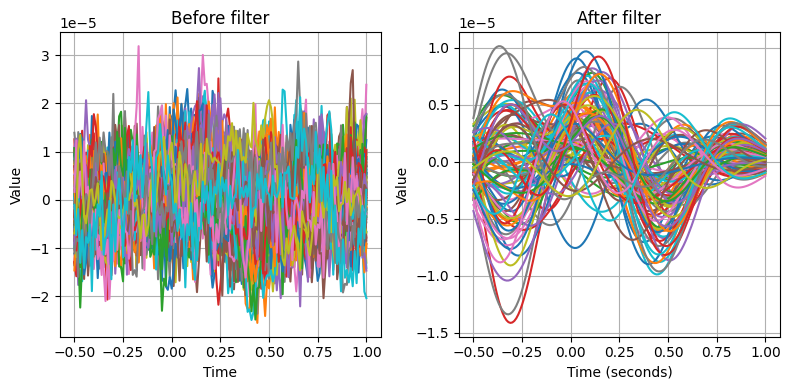

In [30]:
ts = np.mean(selected_data, axis=0)
sfreq = int(1 / (times[1] - times[0]) + 0.5)

mf = MyFilter(sfreq, FilterOption1)
mf.design_filter()
fig = mf.plot_filter()

filtered = mf.filter(ts)
print(filtered.shape)
fig = mf.plot_latest_filtered(times)

filtered = mf.filter(selected_data)
print(filtered.shape)
fig = mf.plot_latest_filtered(times)

In [11]:
selected_data = mf.filter(selected_data)
selected_data_a1 = mf.filter(selected_data_a1)
selected_data_a2 = mf.filter(selected_data_a2)
selected_data_b1 = mf.filter(selected_data_b1)
selected_data_b2 = mf.filter(selected_data_b2)

## Compute exp kernel

In [12]:
# -------------------------------------------------------------------------------------------------
mean = np.mean(selected_data, axis=0)
std = np.std(selected_data)
vmax = np.max(mean) * 2
vmin = np.min(mean) * 2
bins = 100
bins_center = np.linspace(vmin, vmax, bins)
print(f'vmax = {vmax}, vmin = {vmin}, std = {std}, bins = {bins}')

def plot_scores(scores, title='kde score', vmax=vmax, vmin=vmin, bins=bins, cmap=cmap, **kwargs):
    df = pd.DataFrame(scores, columns=times)
    df.index = [f'{e*1e6:0.2f}' for e in bins_center]
    fig, ax = plt.subplots(1, 1)
    sns.heatmap(df, ax=ax, cmap=cmap) #, norm=mpl.colors.LogNorm())
    ax.invert_yaxis()
    sns.scatterplot(x=range(len(times)),y=(mean-vmin)/(vmax-vmin)*bins, color='#33333350', ax=ax)
    sns.lineplot(x=range(len(times)),y=(mean-vmin)/(vmax-vmin)*bins, color='#333333', ax=ax)

    # Additional
    try:
        sns.scatterplot(x=range(len(times)),y=(ts-vmin)/(vmax-vmin)*bins, color='#f0000050', ax=ax)
        # sns.lineplot(x=range(len(times)),y=(ts-vmin)/(vmax-vmin)*bins, color='#f0000050', ax=ax)
    except Exception as err:
        pass
    
    ax.set_title(title)
    fig.tight_layout()
    return fig

# -------------------------------------------------------------------------------------------------
sigma = std
sigma = (bins_center[1] - bins_center[0]) * 5
print(f'std: {std*1e6:0.2f}, sigma: {sigma*1e6:0.2f}')

def exp_kernel(data, bins_center=bins_center, sigma=sigma):
    n = len(data)
    m = len(bins_center)
    data = np.vstack([data]*m).T
    diff = data - bins_center
    num = - np.power(diff, 2)
    den = 2 * sigma * sigma
    exp = np.exp(num / den)
    score = np.sum(exp, axis=0)
    return score

vmax = 5.6911446860733625e-06, vmin = -5.232968465022239e-06, std = 3.1093194848827646e-06, bins = 100

std: 3.11, sigma: 0.55

Computing exp kernel:   0%|          | 0/151 [00:00<?, ?it/s]

exp_score_map has shape (151, 100)

(100, 151)

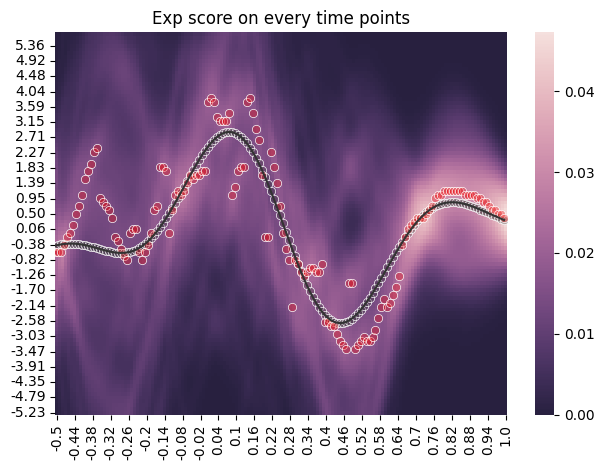

In [13]:
scores = []

concated_data = np.concatenate([selected_data_a2, selected_data_b2], axis=0)

for j in tqdm(range(len(times)), 'Computing exp kernel'):
    # Use concated data for train
    # s = concated_data[:, j]
    
    # Use selected_data for train
    s = selected_data[:, j]
    
    score = exp_kernel(s)
    scores.append(score)

# ntimes x nbins
exp_score_map = np.array(scores)
for e in exp_score_map:
    e /= np.sum(e)

print(f'exp_score_map has shape {exp_score_map.shape}')

scores = exp_score_map.T
print(scores.shape)

ts = bins_center[np.argmax(scores, axis=0)]
fig = plot_scores(scores, title='Exp score on every time points', ts=ts)

plt.show()

(90, 151)
(151, 100)

Computing prob:   0%|          | 0/90 [00:00<?, ?it/s]

(90,)

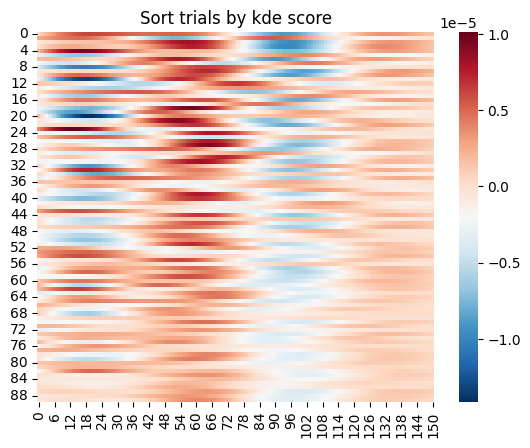

In [14]:
scores = []

print(selected_data.shape, exp_score_map.shape)

for ts in tqdm(selected_data, 'Computing prob'):
    # 151 x 100
    d = np.array([exp_kernel(np.array([e])) for e in ts])
    scores.append(np.sum(d * exp_score_map))

score_array = np.array(scores)
print(score_array.shape)

argsort = np.array(np.argsort([np.sum(e) for e in score_array]))
sns.heatmap(selected_data[argsort], cmap=cmap1)
plt.title('Sort trials by kde score')
plt.show()

Computing prob (a1):   0%|          | 0/472 [00:00<?, ?it/s]

(472,)

Computing prob (a2):   0%|          | 0/59 [00:00<?, ?it/s]

(59,)

Computing prob (b1):   0%|          | 0/720 [00:00<?, ?it/s]

(720,)

Computing prob (b2):   0%|          | 0/90 [00:00<?, ?it/s]

(90,)

,score,class
0,14.460494,a1
1,15.425930,a1
2,13.101435,a1
3,10.170120,a1
4,10.515341,a1
...,...,...
85,9.793517,b2
86,11.859939,b2
87,11.564331,b2
88,7.939942,b2


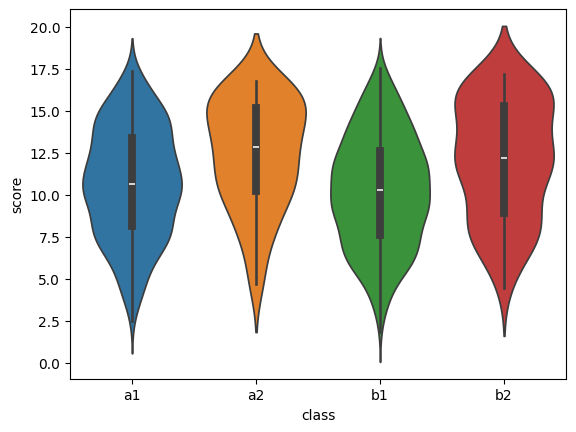

In [15]:
# -----------------------------------------
# Compute scores for unseen data
time_map = [e > -0.2 and e < 0.6 for e in times]

def valuate(sd, class_name):
    scores = []
    for ts in tqdm(sd, f'Computing prob ({class_name})'):
        d = np.array([exp_kernel(np.array([e])) for e in ts[time_map]])
        scores.append(np.sum(d * exp_score_map[time_map]))
    
    score_array = np.array(scores)
    print(score_array.shape)
    
    df = pd.DataFrame(score_array, columns=['score'])
    df['class'] = class_name
    return df

df_a1 = valuate(selected_data_a1, class_name='a1')
df_a2 = valuate(selected_data_a2, class_name='a2')
df_b1 = valuate(selected_data_b1, class_name='b1')
df_b2 = valuate(selected_data_b2, class_name='b2')

df = pd.concat([
    df_a1,
    df_a2,
    df_b1, 
    df_b2
])
display(df)
fig, ax = plt.subplots(1, 1)
sns.violinplot(df, x='class', y='score', hue='class', ax=ax)
plt.show()

ROC of a = 0.65

ROC of b = 0.65

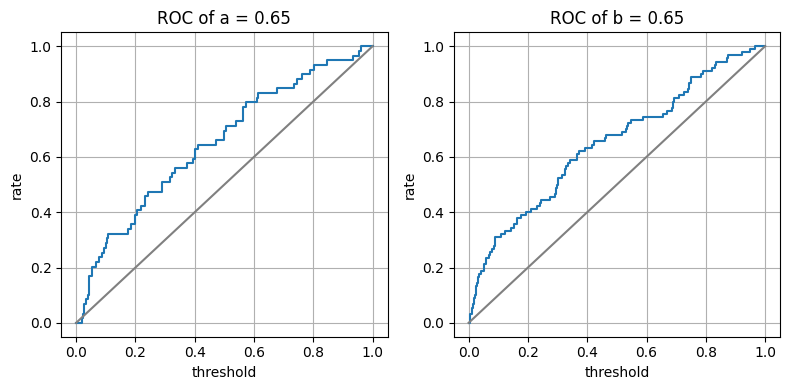

In [16]:
# -------------------------------------------
# Compute ROC
from sklearn.metrics import roc_auc_score, roc_curve

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

for df1, df2, name, ax in zip([df_a1, df_b1], [df_a2, df_b2], ['a', 'b'], axs):
    y_true = np.concatenate([[0] * len(df1), [1] * len(df2)])
    y_score = np.concatenate([df1['score'], df2['score']])
    s = roc_auc_score(y_true, y_score)
    fpr, tpr, threshold = roc_curve(y_true, y_score)
    title = f'ROC of {name} = {s:0.2f}'
    print(title)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='gray')
    # ax.plot(threshold, fpr, label='FPR')
    # ax.plot(threshold, tpr, label='TPR')
    ax.set_xlabel('threshold')
    ax.set_ylabel('rate')
    ax.set_title(title)
    # ax.legend()
    ax.grid()

fig.tight_layout()

plt.show()

## KDE method

Computing kde:   0%|          | 0/151 [00:00<?, ?it/s]

(100, 151)

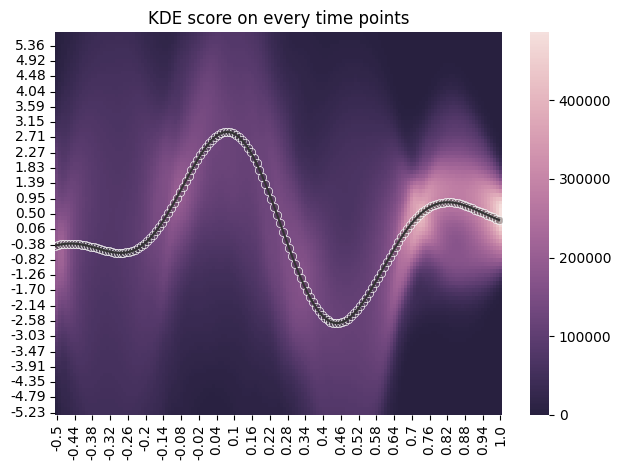

In [17]:
bw_method = 'silverman'
bw_method = 'scott'

'''
Compute kde for every time points
'''

scores = []

for j in tqdm(range(len(times)), 'Computing kde'):
    ts = selected_data[:, j]
    kernel = gaussian_kde(ts, bw_method=bw_method)
    score = kernel(bins_center)
    scores.append(score)

scores = np.array(scores).T
print(scores.shape)

fig = plot_scores(scores, title='KDE score on every time points')
plt.show()

(13590, 2)

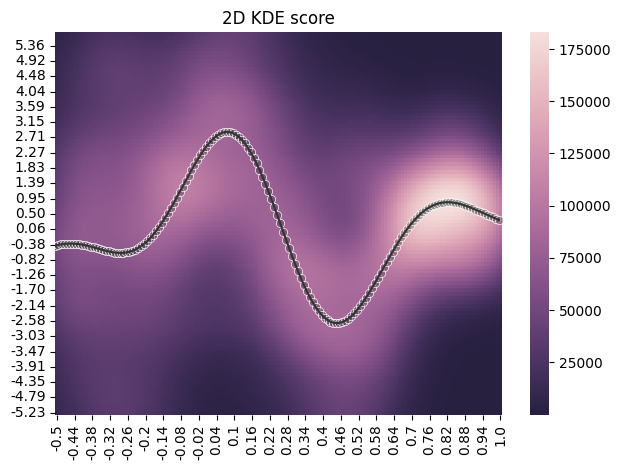

In [18]:
'''
Compute 2D kde
'''
xx, yy = np.meshgrid(times, bins_center)
xy_sample = np.vstack([xx.ravel(), yy.ravel()]).T
xx.shape, xy_sample.shape

expand_times = np.concatenate([times[np.newaxis, :] for _ in range(len(selected_data))])
expand_times.shape
train_data = np.vstack([expand_times.ravel(), selected_data.ravel()]).T
print(train_data.shape)

kernel = gaussian_kde(train_data.T, bw_method=bw_method)
score = kernel(xy_sample.T)
score.shape
resized = score.reshape((100, 151))

fig = plot_scores(resized, title='2D KDE score')
plt.show()

In [19]:
score = kernel(np.vstack([times, mean]))
score_array = [kernel(np.vstack([times, e])) for e in tqdm(selected_data)]
print(np.array(score_array).shape)

  0%|          | 0/90 [00:00<?, ?it/s]

(90, 151)

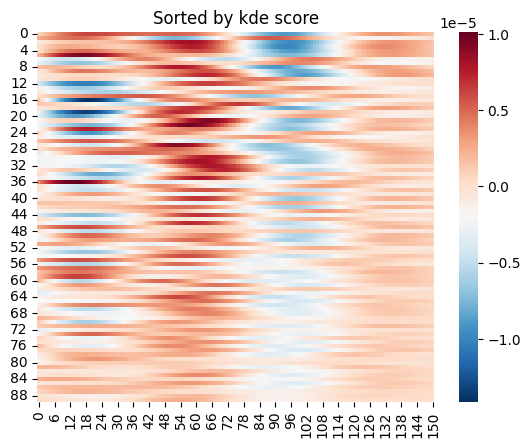

In [20]:
argsort = np.array(np.argsort([np.sum(e) for e in score_array]))
sns.heatmap(selected_data[argsort], cmap=cmap1)
plt.title('Sorted by kde score')
plt.show()

  0%|          | 0/90 [00:00<?, ?it/s]

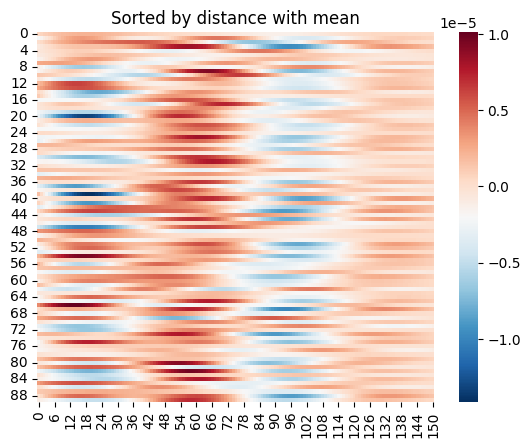

In [21]:
score_array2 = [np.sum(np.power(e-mean, 2)) for e in tqdm(selected_data)][::-1]
argsort2 = np.array(np.argsort([np.sum(e) for e in score_array2]))
sns.heatmap(selected_data[argsort2], cmap=cmap1)
plt.title('Sorted by distance with mean')
plt.show()

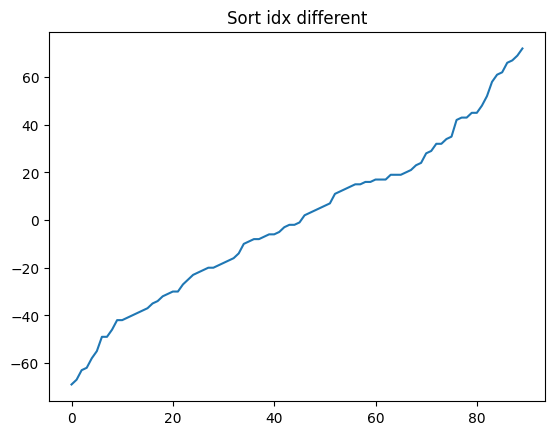

In [22]:
plt.plot(sorted(np.array(argsort) - np.array(argsort2)))
plt.title('Sort idx different')
plt.show()

(151,)
(90, 151)

0.130 sec. elapsed

0.056 sec. elapsed

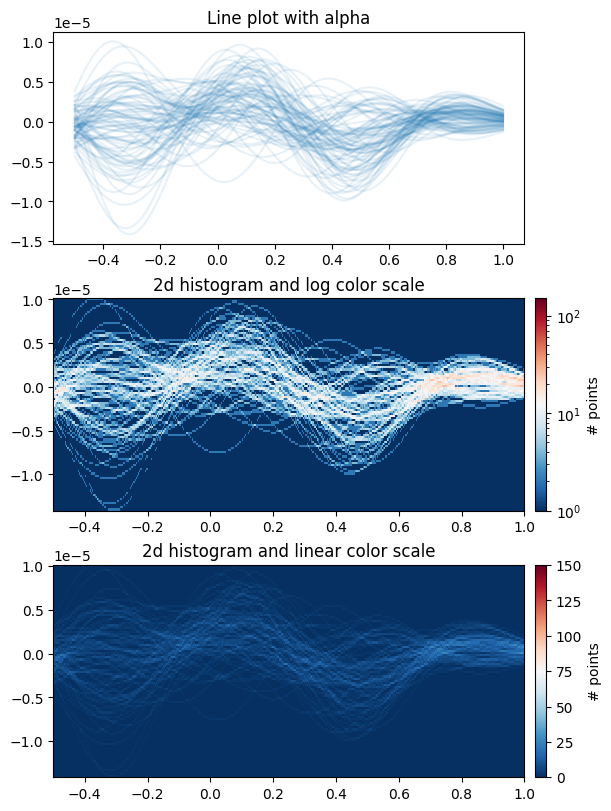

In [23]:
fig, axes = plt.subplots(nrows=3, figsize=(6, 8), layout='constrained')

Y = selected_data
x = times
num_series = len(Y)
print(x.shape, Y.shape)

# Plot series using `plot` and a small value of `alpha`. With this view it is
# very difficult to observe the sinusoidal behavior because of how many
# overlapping series there are. It also takes a bit of time to run because so
# many individual artists need to be generated.
tic = time.time()
axes[0].plot(x, Y.T, color="C0", alpha=0.1)
toc = time.time()
axes[0].set_title("Line plot with alpha")
print(f"{toc-tic:.3f} sec. elapsed")


# Now we will convert the multiple time series into a histogram. Not only will
# the hidden signal be more visible, but it is also a much quicker procedure.
tic = time.time()
# Linearly interpolate between the points in each time series
num_fine = 800
x_fine = np.linspace(x.min(), x.max(), num_fine)
y_fine = np.concatenate([np.interp(x_fine, x, y_row) for y_row in Y])
x_fine = np.broadcast_to(x_fine, (num_series, num_fine)).ravel()


# Plot (x, y) points in 2d histogram with log colorscale
# It is pretty evident that there is some kind of structure under the noise
# You can tune vmax to make signal more visible
h, xedges, yedges = np.histogram2d(x_fine, y_fine, bins=[400, 100])
pcm = axes[1].pcolormesh(xedges, yedges, h.T, cmap=cmap1,
                         norm="log", vmax=1.5e2, rasterized=True)
fig.colorbar(pcm, ax=axes[1], label="# points", pad=0)
axes[1].set_title("2d histogram and log color scale")

# Same data but on linear color scale
pcm = axes[2].pcolormesh(xedges, yedges, h.T, cmap=cmap1,
                         vmax=1.5e2, rasterized=True)
fig.colorbar(pcm, ax=axes[2], label="# points", pad=0)
axes[2].set_title("2d histogram and linear color scale")

toc = time.time()
print(f"{toc-tic:.3f} sec. elapsed")
plt.show()

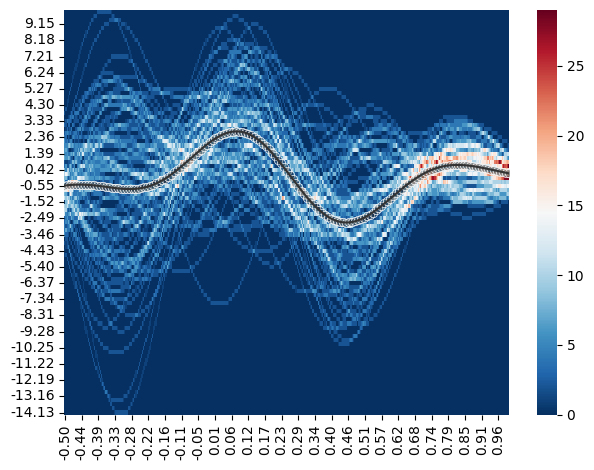

In [24]:
df = pd.DataFrame(h.T, columns=[f'{e:0.2f}' for e in xedges[:-1]])
df.index = [f'{e*1e6:0.2f}' for e in yedges[:-1]]

fig, ax = plt.subplots(1, 1)
sns.heatmap(df, ax=ax, cmap=cmap1)
ax.invert_yaxis()
sns.scatterplot(
    x=np.linspace(0, h.shape[0], 151),
    y=(mean-yedges[0])/(yedges[-1]-yedges[0])*100,
    color='#33333350', ax=ax)
sns.lineplot(
    x=np.linspace(0, h.shape[0], 151),
    y=(mean-yedges[0])/(yedges[-1]-yedges[0])*100,
    color='#333333',
    ax=ax)
fig.tight_layout()
plt.show()